In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json

# read into the csv file and assign it a dataframe
traffic_path = "traffic.csv"
traffic_df = pd.read_csv(traffic_path)

### Data cleaning and formatting

In [19]:
# select columns that we want
traffic_df = traffic_df[["TIME","SPEED","BUS_COUNT","NUM_READS","MONTH"]]
# convert items in time column to datetime-type items and 
traffic_df["TIME"] = pd.to_datetime(traffic_df["TIME"])
# retrive information of month,day and year respectively
traffic_df["MONTH"]= traffic_df["TIME"].dt.month
traffic_df["DAY"] = traffic_df["TIME"].dt.day
traffic_df["YEAR"] = traffic_df["TIME"].dt.year
# relocate the columns and rows
traffic_df = traffic_df[["TIME","YEAR","MONTH","DAY","SPEED","BUS_COUNT","NUM_READS"]]
traffic_df = traffic_df.sort_values(["YEAR","MONTH"],ascending=True)
# select the rows that we want to match the time period of traffic and that of air quality together, drop rows from 2020 May to 2018 July
traffic_df = traffic_df.drop(traffic_df[(traffic_df["YEAR"]==2020)&((traffic_df["MONTH"]==5)|(traffic_df["MONTH"]==6)|(traffic_df["MONTH"]==7))].index)
traffic_df
#traffic_df['TIME'] = traffic_df['TIME'].dt.date


ym_df=traffic_df.groupby(["YEAR","MONTH"])
ym_df.count().head(10)

/Users/ryanngreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ryanngreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ryanngreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

TIME   DAY  SPEED  BUS_COUNT  NUM_READS
YEAR MONTH                                         
2018 3      3034  3034   3034       3034       3034
     4      3850  3850   3850       3850       3850
     5      4148  4148   4148       4148       4148
     6      4132  4132   4132       4132       4132
     7      4310  4310   4310       4310       4310
     8      3856  3856   3856       3856       3856
     9      4141  4141   4141       4141       4141
     10     4271  4271   4271       4271       4271
     11     3938  3938   3938       3938       3938
     12     4233  4233   4233       4233       4233

In [20]:
#add date column that only includes the date of the traffic measurement recording
traffic_df["Date"]=traffic_df['TIME'].dt.date
#date_df=traffic_df

date_group=traffic_df.groupby("Date")
date_group.count()

#Get the daily average for the number of cars, bus, and the speed people were going

day_speed=round(date_group["SPEED"].mean(),2)
day_bus=round(date_group["BUS_COUNT"].mean(),0)
day_num=round(date_group["NUM_READS"].mean(),0)

day_motor=pd.DataFrame({"SPEED":day_speed,
             "BUS COUNT":day_bus,
             "NUM COUNT":day_num})
day_motor=day_motor.reset_index()
day_motor

,Date,SPEED,BUS COUNT,NUM COUNT
0,2018-03-09,14.85,107.0,1558.0
1,2018-03-10,18.10,48.0,689.0
2,2018-03-11,19.20,36.0,524.0
3,2018-03-12,16.80,83.0,1229.0
4,2018-03-13,16.93,85.0,1277.0
...,...,...,...,...
768,2020-04-26,22.61,32.0,596.0
769,2020-04-27,19.96,72.0,1302.0
770,2020-04-28,19.55,77.0,1370.0
771,2020-04-29,19.47,72.0,1292.0


For Speed, values below 14.395000000000001 and values above 22.195  are outliers.
For Bus, values below 46.075 and values above 89.925  are outliers.
For Num, values below 835.075 and values above 1455.925  are outliers.


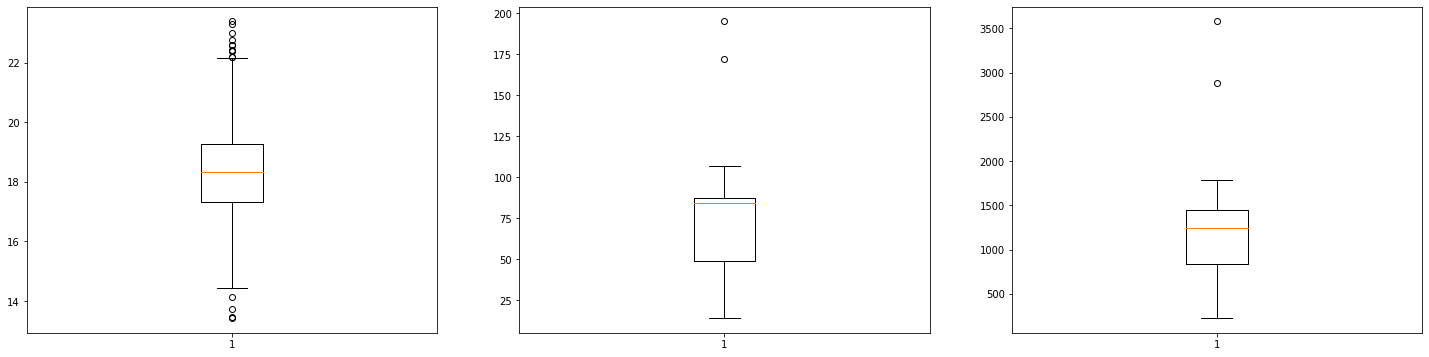

In [21]:
#find outliers for each pollutant daily measurement and remove them from the dataframe
speed=day_motor["SPEED"]
bus=day_motor["BUS COUNT"]
num=day_motor["NUM COUNT"]

##add subset 
s_upperq=speed.quantile(.75)
s_lowerq=speed.quantile(.25)
s_IQR=s_upperq-s_lowerq

# Determine outliers using upper and lower bounds
s_upperb=s_upperq+(1.5*s_IQR)
s_lowerb=s_lowerq-(1.5*s_IQR)

b_upperq=bus.quantile(.75)
b_lowerq=bus.quantile(.25)
b_IQR=b_upperq-b_lowerq

# Determine outliers using upper and lower bounds
b_upperb=b_upperq+(1.5*s_IQR)
b_lowerb=b_lowerq-(1.5*s_IQR)


n_upperq=num.quantile(.75)
n_lowerq=num.quantile(.25)
n_IQR=n_upperq-n_lowerq

# Determine outliers using upper and lower bounds
n_upperb=n_upperq+(1.5*s_IQR)
n_lowerb=n_lowerq-(1.5*s_IQR)

boxes=[speed,bus,num]
l_bounds=[s_lowerb,b_lowerb,n_lowerb]
u_bounds=[s_upperb,b_upperb,n_upperb]

#counter=0

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1,ncols=3,figsize=(25,6))
  
print(f"For Speed, values below {s_lowerb} and values above {s_upperb}  are outliers.")
print(f"For Bus, values below {b_lowerb} and values above {b_upperb}  are outliers.")
print(f"For Num, values below {n_lowerb} and values above {n_upperb}  are outliers.")
    
ax1.boxplot(speed)
ax2.boxplot(bus)
ax3.boxplot(num)

plt.show()

In [22]:
#remove the outliers
day_motor=day_motor.loc[(day_motor["SPEED"]>s_lowerb) &
             (day_motor["SPEED"]<s_upperb) &
             (day_motor["BUS COUNT"]>b_lowerb) &
             (day_motor["BUS COUNT"]<b_upperb) &
              (day_motor["NUM COUNT"]>n_lowerb) &
             (day_motor["NUM COUNT"]<n_upperb)]

day_motor.head()

,Date,SPEED,BUS COUNT,NUM COUNT
3,2018-03-12,16.80,83.0,1229.0
4,2018-03-13,16.93,85.0,1277.0
5,2018-03-14,16.49,87.0,1291.0
6,2018-03-15,16.97,86.0,1281.0
7,2018-03-16,15.86,89.0,1301.0
